# Setup

In [1]:
%%sh
pip install -q dash
pip install -q dash_core_components
pip install -q dash_html_components
pip install -q dash_bootstrap_components
pip install -q dash_table

In [2]:
%%sh
# get ngrok
curl -O https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
unzip ngrok-stable-linux-amd64.zip

Archive:  ngrok-stable-linux-amd64.zip
  inflating: ngrok                   


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 13.1M  100 13.1M    0     0  12.3M      0  0:00:01  0:00:01 --:--:-- 12.3M


# Dash

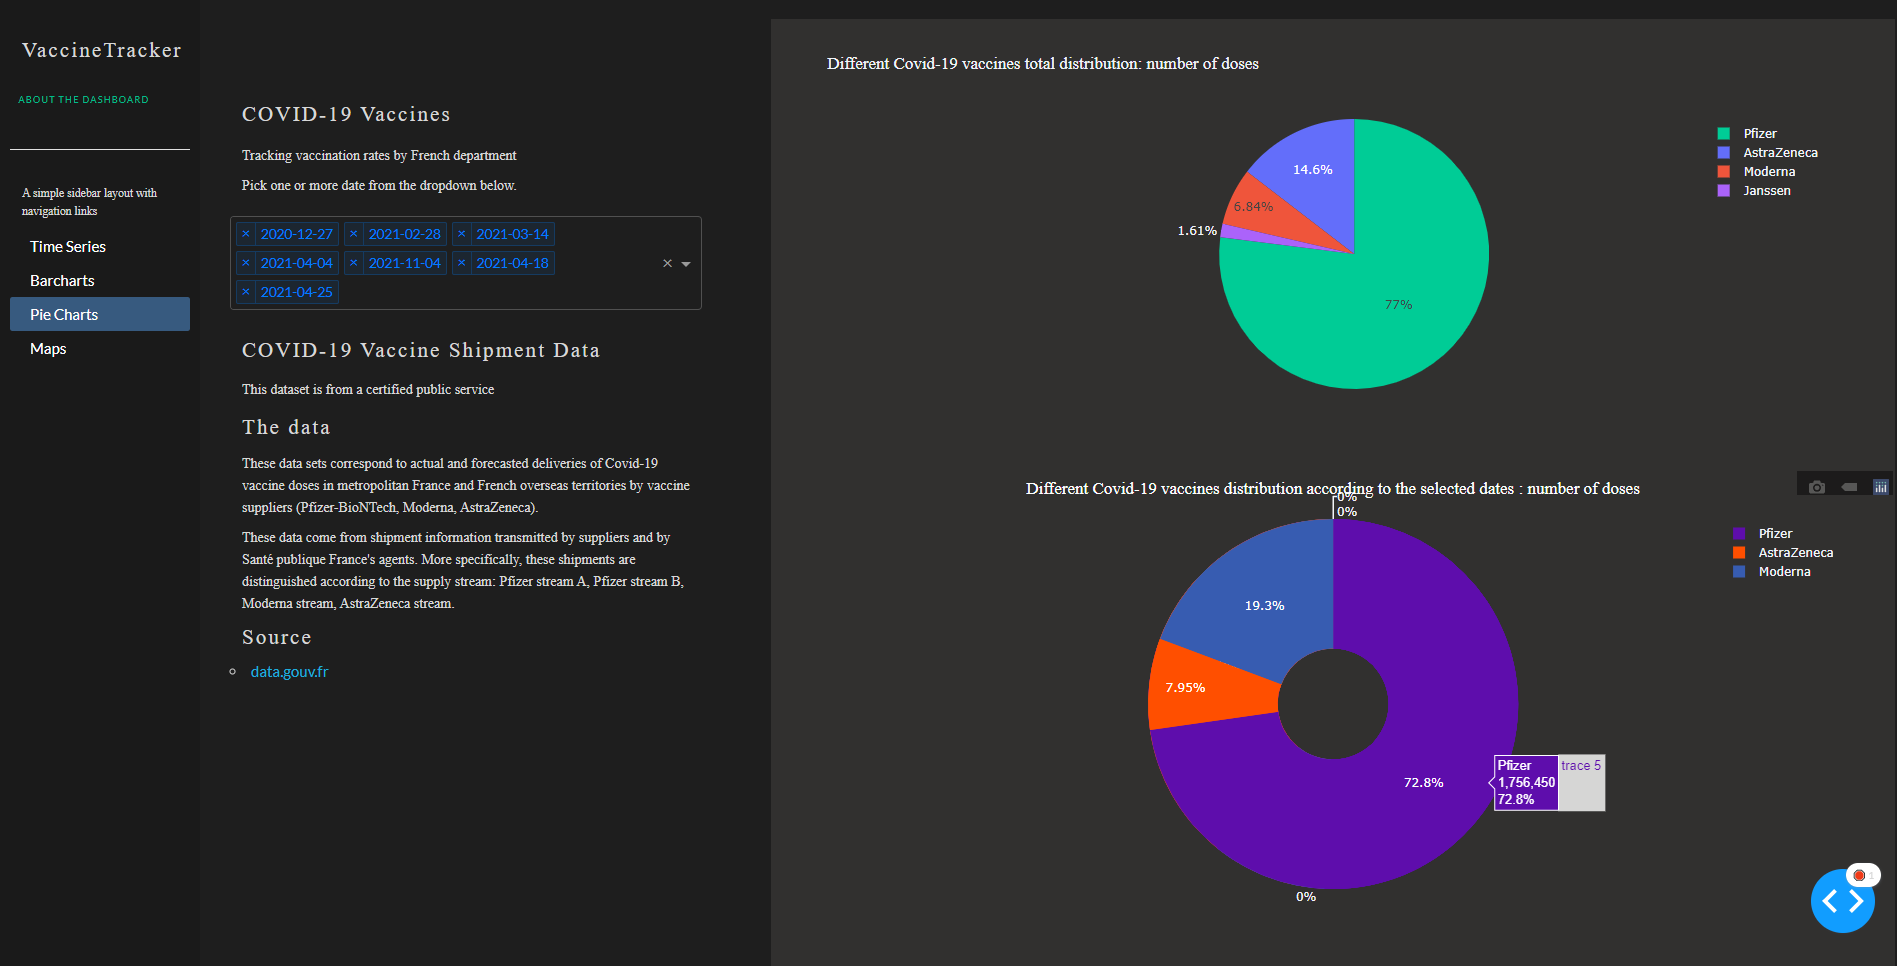

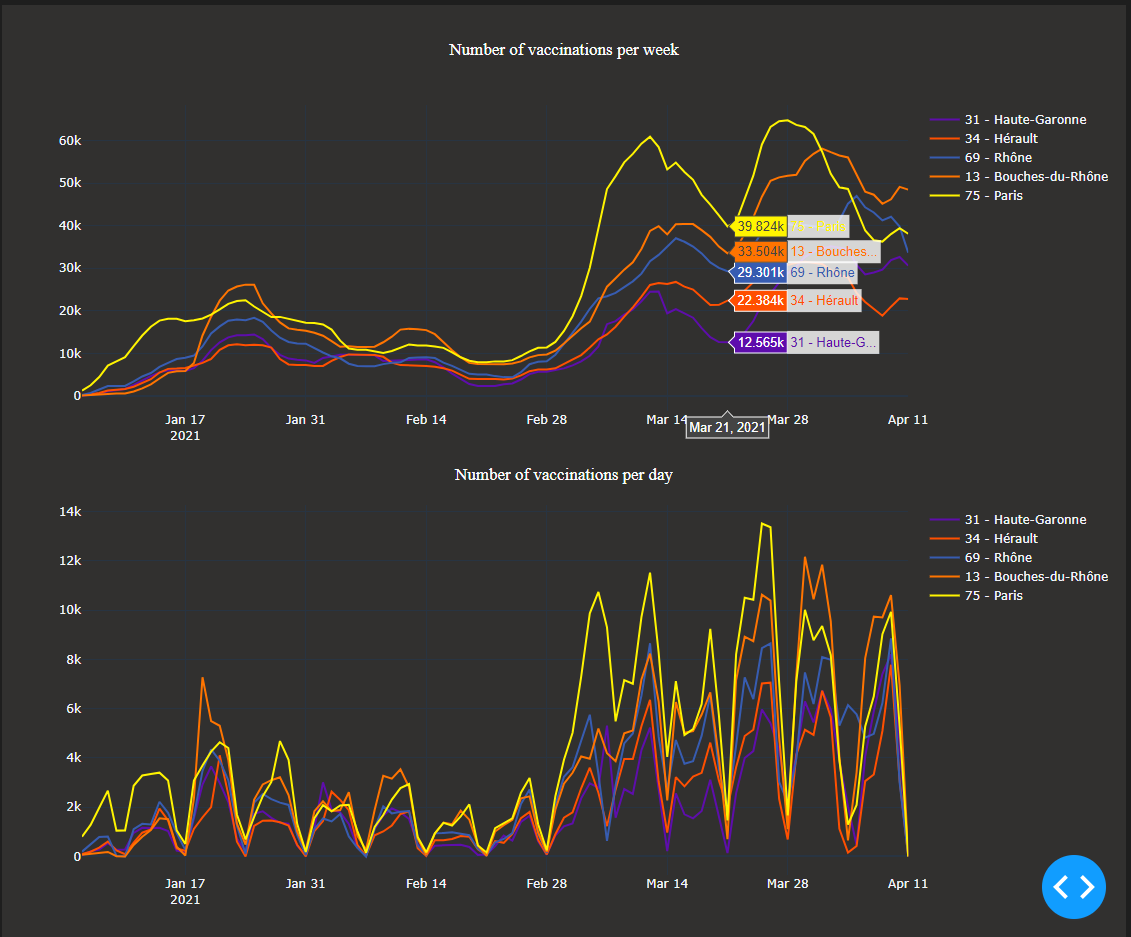

Source : https://www.data.gouv.fr/fr/datasets/donnees-relatives-aux-livraisons-de-vaccins-contre-la-covid-19/

+ If you want your dashboard to look like the one above, please download the file [style.css](https://github.com/STATWORX/blog/blob/master/DashApp/assets/style.css). Dash will automatically load any .css-file placed in a folder named **assets**. 
+ To do this, create a new folder named **assets** ont the Google Colab "Files" on the left (folder icon). Put the .css file in this folder.

In [ ]:
%%writefile dash_app.py
 
import dash
import pandas as pd
import dash_core_components as dcc
import dash_html_components as html
from dash.dependencies import Input, Output, State
import plotly.express as px
import plotly.graph_objs as go
import dash_bootstrap_components as dbc

# Import datas

url1 = 'https://raw.githubusercontent.com/jihene-b3/covidviz/main/covidviz/dashboard/data/vac_code_nom_dep.csv'
url2 = 'https://raw.githubusercontent.com/jihene-b3/covidviz/main/covidviz/dashboard/data/flux-total-nat.csv'


df = pd.read_csv(url1, index_col=0, parse_dates=True)
df.index = pd.to_datetime(df['date'])


dflux = pd.read_csv(url2, index_col=0, parse_dates=True, delimiter =';')
dflux.index = dflux.index.astype(str)

map3Durl = 'https://raw.githubusercontent.com/jihene-b3/covidviz/main/covidviz/dashboard/visualisation/html_files/vacc_daily_map3D.html'



# Creates a list of dictionaries, which have the keys 'label' and 'value'.
def get_options(list_options):
  dict_list = []
  for i in list_options:
    dict_list.append({'label': i, 'value': i})
  return dict_list

# options=[{'label': 'Haute-Garonne', 'value': '31'},{'label': 'Tarn', 'value': '81'},{'label': 'Aveyron', 'value': '12'}]






about_app = html.Div(
    children=[
        html.Ul([
            html.Li(
                html.A('Github',
                       href='https://github.com/jihene-b3/covidviz/tree/main/covidviz/dashboard')),
            html.Li(
                html.A('Source', href='https://www.data.gouv.fr/fr/datasets/donnees-relatives-aux-personnes-vaccinees-contre-la-covid-19-1/')),
        ]),
        html.P('''
        This interactive data visualisation dashboard illustrates what is possible using 
        the Santé Publique France source & python Plotly Dash library 
        to deliver some simple & powerful insights into the global data of the 
        Covid-19 vaccines / vaccinated persons. The source code is in the GitHub link above.
        '''),
        html.P('''
        The dashboard is optimised for desktop/laptop - it may work on tablet, however is clunky on mobile.
        '''),
        html.P('''
        All plots are interactive.
        '''),
        html.P('''
        The code is entirely Open Source.  
        '''),
        html.P('''
        Hosting (for free) via Heroku - see the GitHub link for details. 
        '''),
        html.P('''
        There is an accompanying Jupyter Notebook in the Open Source GitHub Repo (above) 
        ''')
    ]
)



modal = html.Div(
    [
        dbc.Button('About the Dashboard',
                   id='open_modal',
                   color='link'),
        dbc.Modal(
            [
                dbc.ModalHeader('COVID-19 Dashboard | Covid-19 Vaccines Data'),
                dbc.ModalBody(
                    children=[
                        about_app,
                    ]
                ),
                dbc.ModalFooter(
                    dbc.Button('Close',
                               id='close',
                               color='link',
                               className='ml-auto')
                ),
            ],
            id='modal',
        ),
    ]
)








# The style arguments for the sidebar. We use position :fixed and a fixed width
SIDEBAR_STYLE = {
    "position": "fixed",
    "top": 0,
    "left": 0,
    "bottom": 0,
    "width": "20rem",
    "padding": "2rem 1rem",
    "background-color": "#1a1a1a",
}

# The styles for the main content position it to the right of the sidebar and
# add some padding.

CONTENT_STYLE = {
    "margin-left": "18rem",
    "margin-right": "2rem",
    "padding": "2rem 1rem",
}

sidebar = html.Div(
    [
        html.H2("VaccineTracker", className="display-6"),
        html.Div(className='header', children=[modal]),
        html.Hr(),
        html.P(
            "A simple sidebar layout with navigation links", className="lead"
        ),
        dbc.Nav(
            [
                dbc.NavLink("Time Series", href="/", active="exact"),
                dbc.NavLink("Barcharts", href="/page-1", active="exact"),
                dbc.NavLink("Pie Charts", href="/page-2", active="exact"),
                dbc.NavLink("Maps", href="/page-3", active="exact")
            ],
            vertical=True,
            pills=True,
        ),
    ],
    style=SIDEBAR_STYLE,
)

content = html.Div(id="page-content", style=CONTENT_STYLE)








TIMESERIES = html.Div(children=[
             html.Div(className='row',
                 children=[
                    html.Div(className='four columns div-user-controls',
                             children=[
                                 
                                 html.H2('Number of vaccination'),
                                 html.P('Tracking vaccination rates by French department'),
                                 html.P('Pick one or more location from the dropdown below.'),
                                 html.Div(className='div-for-dropdown',
                                          children=[
                                                    dcc.Dropdown(id='locselector',
                                                                 options=get_options(df['nom'].unique()),
                                                                 multi=True,
                                                                 value=[df['nom'].sort_values()[0]],
                                                                 style={'backgroundColor': '#1E1E1E'},
                                                                 className='locselector')
                                                    ],
                                          style={'color': '#1E1E1E'})
                                       
                                       ]),
                    html.Div(className='eight columns div-for-charts bg-grey',
                             children=[
    dcc.Graph(id='ts_weekly',
              config={'displayModeBar': False},
              animate=True),
    dcc.Graph(id='ts_daily',
              config={'displayModeBar': False},
              animate=True) ])
                           
                    
                    
                              ])
    ])


BARCHARTS = html.Div(children=[
             html.Div(className='row',
                 children=[
                    html.Div(className='four columns div-user-controls',
                             children=[
                                 
                                 html.H2('Type of vaccination'),
                                 html.P('Tracking vaccination rates by French department'),
                                 html.P('Pick one or more location from the dropdown below.'),
                                 html.Div(className='div-for-dropdown',
                                          children=[
                                                    dcc.Dropdown(id='locselector',
                                                                 options=get_options(df['nom'].unique()),
                                                                 multi=True,
                                                                 value=[df['nom'].sort_values()[0]],
                                                                 style={'backgroundColor': '#1E1E1E'},
                                                                 className='locselector')
                                                    ],
                                          style={'color': '#1E1E1E'}),
                                       
                                html.H3('COVID-19 : Number of vaccinations by department'),
                                html.P('This dataset is from a certified public service'),
                                html.H4('The data'),
                                html.P('These data sets correspond to actual and forecasted deliveries of Covid-19 vaccine doses in metropolitan France and French overseas territories by vaccine suppliers (Pfizer-BioNTech, Moderna, AstraZeneca).'),
                                html.P("These data come from shipment information transmitted by suppliers and by Santé publique France's agents. More specifically, these shipments are distinguished according to the supply stream: Pfizer stream A, Pfizer stream B, Moderna stream, AstraZeneca stream."),
                                html.H5('Source'),
                                html.Ul([
                                         html.Li(
                                             html.A('data.gouv.fr', href='https://www.data.gouv.fr/fr/datasets/donnees-relatives-aux-livraisons-de-vaccins-contre-la-covid-19/'))])
                                       
                                       ]),
                    html.Div(className='eight columns div-for-charts bg-grey',
                             children=[
    dcc.Graph(id='bc_total',
              config={'displayModeBar': False},
              animate=True) ])
                           
                    
                    
                              ])
    ])




PIECHARTS = html.Div(children=[
             html.Div(className='row',
                 children=[
                    html.Div(className='four columns div-user-controls',
                             children=[
                                 
                                 html.H2('COVID-19 Vaccines'),
                                 html.P('Tracking Covid-19 Vaccines Distribution'),
                                 html.P('Pick one or more date from the dropdown below.'),
                                 html.Div(className='div-for-dropdown',
                                          children=[
                                                    dcc.Dropdown(id='dateselector',
                                                    options=get_options(dflux.index.unique()),
                                                    multi=True,
                                                    value=[dflux.index.sort_values()[0]],
                                                    style={'backgroundColor': '#1E1E1E'},
                                                    className='dateselector')
                                                    ],
                                          style={'color': '#1E1E1E'}),
                                html.H3('COVID-19 Vaccine Shipment Data'),
                                html.P('This dataset is from a certified public service'),
                                html.H4('The data'),
                                html.P('These data sets correspond to actual and forecasted deliveries of Covid-19 vaccine doses in metropolitan France and French overseas territories by vaccine suppliers (Pfizer-BioNTech, Moderna, AstraZeneca).'),
                                html.P("These data come from shipment information transmitted by suppliers and by Santé publique France's agents. More specifically, these shipments are distinguished according to the supply stream: Pfizer stream A, Pfizer stream B, Moderna stream, AstraZeneca stream."),
                                html.H5('Source'),
                                html.Ul([
                                         html.Li(
                                             html.A('data.gouv.fr', href='https://www.data.gouv.fr/fr/datasets/donnees-relatives-aux-livraisons-de-vaccins-contre-la-covid-19/'))])

                                       
                                       ]),
                    html.Div(className='eight columns div-for-charts bg-grey',
                             children=[dcc.Graph(id='pie-chart-classic',
          config={'displayModeBar': False},
          animate=True,
          figure=px.pie(dflux,
                        values='nb_doses', 
                        names='type_de_vaccin',
                        color='type_de_vaccin',
                        title='Different Covid-19 vaccines total distribution: number of doses',
                        template='plotly_dark').update_layout(
                                   {'plot_bgcolor': 'rgba(0, 0, 0, 0)',
                                    'paper_bgcolor': 'rgba(0, 0, 0, 0)'})
                                    ),
                                       dcc.Graph(id="pie-chart")
                                       ])
                           
                    
                    
                              ])
    ])


MAP = html.Div(children=[
             html.Div(className='row',
                 children=[
                           html.Div(className='three columns div-user-controls',
                             children=[
                                 html.H2('Map animation'),
                                 html.P('Map generated with Kepler.gl with MapGL rendering'),
                                 html.P('Data from Santé Publique France and Grégoire David - geojson file for the for the geometric contours')]),
                           
                    html.Div(className='nine columns div-for-charts bg-grey',
                             children=[
                                       html.Iframe(src= map3Durl,
                style={"height": "1067px", "width": "100%"})
                             ])])])

# [dbc.themes.BOOTSTRAP]





app = dash.Dash(__name__, external_stylesheets = [dbc.themes.DARKLY], suppress_callback_exceptions=True)
 
app.layout = html.Div([html.Div([dcc.Location(id="url"), sidebar, content])])

#html.Div(className='header', children=[modal])


@app.callback(Output("page-content", "children"), [Input("url", "pathname")])
def render_page_content(pathname):
    if pathname == "/":
        return TIMESERIES
 
    elif pathname == "/page-1":
        return BARCHARTS

    elif pathname == "/page-2":
        return PIECHARTS
    
    elif pathname == "/page-3":
        return MAP
        
    # If the user tries to reach a different page, return a 404 message
    return dbc.Jumbotron(
        [
            html.H1("404: Not found", className="text-danger"),
            html.Hr(),
            html.P(f"The pathname {pathname} was not recognised..."),
        ]
    )

@app.callback(
    Output('modal', 'is_open'),
    [Input('open_modal', 'n_clicks'), Input('close', 'n_clicks')],
    [State('modal', 'is_open')],
)
def toggle_modal(n1, n2, is_open):
    if n1 or n2:
        return not is_open
    return is_open

# Callback for timeseries number of vaccinations per week
@app.callback(Output('ts_weekly', 'figure'),
              [Input('locselector', 'value')])

def update_ts_week(selected_dropdown_value):
    trace1 = []
    df_sub = df
    for nom in selected_dropdown_value:
        trace1.append(go.Scatter(x=df_sub[df_sub['nom'] == nom].index,
                                 y=df_sub[df_sub['nom'] == nom]['weekly'],
                                 mode='lines',
                                 opacity=1,
                                 name= nom,
                                 textposition='bottom center'))
    traces = [trace1]
    data = [val for sublist in traces for val in sublist]
    figure = {'data': data,
              'layout': go.Layout(
                  colorway=["#5E0DAC", '#FF4F00', '#375CB1', '#FF7400', '#FFF400', '#FF0056'],
                  template='plotly_dark',
                  paper_bgcolor='rgba(0, 0, 0, 0)',
                  plot_bgcolor='rgba(0, 0, 0, 0)',
                  margin={'b': 15},
                  hovermode='x',
                  autosize=True,
                  title={'text': 'Number of vaccinations per week', 'font': {'color': 'white'}, 'x': 0.5},
                  xaxis={'range': [df_sub.index.min(), df_sub.index.max()]},
              ),
 
              }
 
    return figure
 
 
# Callback for timeseries number of vaccinations per day
 
@app.callback(Output('ts_daily', 'figure'),
              [Input('locselector', 'value')])

def update_ts_daily(selected_dropdown_value):
    #Draw traces of the feature 'daily' based one the currently selected location
    trace2 = []
    df_sub = df
    # Draw and append traces for each location
    for nom in selected_dropdown_value:
        trace2.append(go.Scatter(x=df_sub[df_sub['nom'] == nom].index,
                                 y=df_sub[df_sub['nom'] == nom]['daily'],
                                 mode='lines',
                                 opacity=1,
                                 name=nom,
                                 textposition='bottom center'))
    traces = [trace2]
    data = [val for sublist in traces for val in sublist]
 
    # Define Figure
 
    figure = {'data': data,
              'layout': go.Layout(
                  colorway=["#5E0DAC", '#FF4F00', '#375CB1', '#FF7400', '#FFF400', '#FF0056'],
                  template='plotly_dark',
                  paper_bgcolor='rgba(0, 0, 0, 0)',
                  plot_bgcolor='rgba(0, 0, 0, 0)',
                  margin={'t': 50},
                  height=500,
                  hovermode='x',
                  autosize=True,
                  title={'text': 'Number of vaccinations per day', 'font': {'color': 'white'}, 'x': 0.5},
                  xaxis={'range': [df_sub.index.min(), df_sub.index.max()]},
              ),
              }
 
    return figure



# Callback for timeseries number of vaccinations per day
 
@app.callback(Output('bc_total', 'figure'),
              [Input('locselector', 'value')])

def update_bc_total(selected_dropdown_value):
    #Draw traces of the feature 'daily' based one the currently selected location
    trace3 = []
    df_sub = df
    # Draw and append traces for each location
    for nom in selected_dropdown_value:
        trace3.append(go.Bar(x=df_sub[df_sub['nom'] == nom]['nom'],
                             y=df_sub[df_sub['nom'] == nom]['tot_vacc'],
                             text=df_sub[df_sub['nom'] == nom]['nom']))
    traces = [trace3]
    data = [val for sublist in traces for val in sublist]
 
    # Define Figure
 
    figure = {'data': data,
              'layout': go.Layout(
                  colorway=["#5E0DAC", '#FF4F00', '#375CB1', '#FF7400', '#FFF400', '#FF0056'],
                  template='plotly_dark',
                  paper_bgcolor='rgba(0, 0, 0, 0)',
                  plot_bgcolor='rgba(0, 0, 0, 0)',
                  margin={'t': 50},
                  height=500,
                  hovermode='x',
                  autosize=True,
                  title={'text': 'Total vaccinations', 'font': {'color': 'white'}, 'x': 0.5},
              ),
              }
 
    return figure


@app.callback(Output("pie-chart", "figure"), 
    [Input("dateselector", "value")])


def generate_chart(selected_dropdown_value):    
    
    trace4 = []
    df_sub = dflux

    for date in selected_dropdown_value:
        trace4.append(go.Pie(values= df_sub[df_sub.index.astype(str) == date]['nb_doses'],
                             labels= df_sub[df_sub.index.astype(str) == date]['type_de_vaccin'],
                             hole=.3))
    traces = [trace4]
    data = [val for sublist in traces for val in sublist]

    figure = {'data': data,
              'layout': go.Layout(
                  colorway=["#5E0DAC", '#FF4F00', '#375CB1', '#FF7400', '#FFF400', '#FF0056'],
                  template='plotly_dark',
                  paper_bgcolor='rgba(0, 0, 0, 0)',
                  plot_bgcolor='rgba(0, 0, 0, 0)',
                  margin={'t': 50},
                  height=500,
                  hovermode='x',
                  autosize=True,
                  title={'text': 'Different Covid-19 vaccines distribution according to the selected dates : number of doses', 'font': {'color': 'white'}, 'x': 0.5},
              ),
              }
 
    return figure




 
 
 
 
app.run_server(debug=True)

Overwriting dash_app.py


In [ ]:
# Launch ngrok

get_ipython().system_raw('./ngrok http 8050 &')

In [ ]:
%%sh
# Get url with ngrok.

# Click on the URL link that appears after keeping the dash app running.
# The link displays the dashboard.

curl -s http://localhost:4040/api/tunnels | python3 -c "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

https://10e235904418.ngrok.io


+ Activate the next cell and go back to the link of second last cell to display the dashboard.
+ Keep the cell work with the Dash app running.

In [ ]:
#Run the dash app and get the localhost

#Let the cell running to click on the url ngrok
!python dash_app.py

Dash is running on http://127.0.0.1:8050/

 * Serving Flask app "dash_app" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: on


If the website crashes (server not optimized enough/ errors), you can generate a new ngrok URL by : 
+ Relaunching the "Launch ngrok" cell, 
+ Then, relaunching the one with "Get URL with ngrok" 
+ And finally launch ***dash_app.py***